In [1]:
import math
from random import random
from functools import partial

import torch
import torch.nn.functional as F
from torch import nn, einsum
import pathlib
from pathlib import Path

import torchvision.transforms as T

from einops import rearrange, repeat

from vae import VQGanVAE
from t5 import t5_encode_text, get_encoded_dim, DEFAULT_T5_NAME

from tqdm.auto import tqdm

from matplotlib import pyplot as plt

from attend import Attend
from PIL import Image

/home/ubuntu/anaconda3/envs/muse/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/ubuntu/anaconda3/envs/muse/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def l2norm(t):
  return F.normalize(t, dim = -1)

In [3]:
class LayerNorm(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.gamma = nn.Parameter(torch.ones(dim))
    self.register_buffer('beta', torch.zeros(dim))

  def forward(self, x):
    return F.layer_norm(x, x.shape[-1:], self.gamma, self.beta)

In [4]:
class GEGLU(nn.Module):
  def forward(self, x):
    x, gate = x.chunk(2, dim = -1)
    return gate * F.gelu(x)

In [5]:
def FeedForward(dim, mult = 4):
  inner_dim = int(dim * mult * 2 / 3)
  return nn.Sequential(
    LayerNorm(dim),
    nn.Linear(dim, inner_dim * 2, bias = False),
    GEGLU(),
    LayerNorm(inner_dim),
    nn.Linear(inner_dim, dim, bias = False)
  )

In [6]:
class Attention(nn.Module):
  def __init__(
      self,
      dim,
      dim_head = 64,
      heads = 8,
      cross_attend = False,
      # the similarity matrix is multiplied by scale/sqrt(d_k)
      scale = 8,
      flash = True,
      dropout = 0.
  ):
    super().__init__()
    self.scale = scale
    self.heads = heads

    inner_dim = dim_head * heads

    self.cross_attend = cross_attend
    self.norm = LayerNorm(dim)

    self.attend = Attend(
      flash = flash,
      dropout = dropout,
      scale = scale
    )

    self.null_kv = nn.Parameter(torch.randn(2, heads, 1, dim_head))

    self.to_q = nn.Linear(dim, inner_dim, bias = False)
    self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)

    self.q_scale = nn.Parameter(torch.ones(dim_head))
    self.k_scale = nn.Parameter(torch.ones(dim_head))

    self.to_out = nn.Linear(inner_dim, dim, bias = False)

  def forward(
      self,
      # assuming batch x number of entries x entry size
      x,
      context = None,
      context_mask = None
  ):
    # if cross attend we must have context
    # because that will be used as keys and values
    assert not ((context is not None) ^ self.cross_attend)

    # entry size
    n = x.shape[-2] 
    h, is_cross_attn = self.heads, context is not None

    x = self.norm(x)

    kv_input = context if self.cross_attend else x

    q, k, v = (self.to_q(x), *self.to_kv(kv_input).chunk(2, dim = -1))

    # split the data across the size dimension
    # to enable multihead attention
    # q[b][h][n] is a d-dimensional vector representing the n-th query of the h-th # head
    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))

    # one key and one query for each head, where the contents are random
    nk, nv = self.null_kv

    # extend nk and nv to obtain a batch of nks and nvs
    nk, nv = map(lambda t: repeat(t, 'h 1 d -> b h 1 d', b = x.shape[0]), (nk, nv))

    k = torch.cat((nk, v), dim = -2)
    v = torch.cat((nv, v), dim = -2)

    # normalize each individual query and key
    q, k = map(l2norm, (q, k))
    q = q * self.q_scale
    k = k * self.k_scale

    if context_mask is not None:
      # context_mask[b][j] = 1 signifies that in the bth batch, the jth key-value pair should not be used
      context_mask = repeat(context_mask, 'b j -> b h i j', h = h, i = n)
      # adds a column of 1s to the left
      # ignore the first token, which is the random values
      context_mask = F.pad(context_mask, (1, 0), value = True)

    out = self.attend(q, k, v, mask = context_mask)

    # concatenate the outputs of the heads
    out = rearrange(out, 'b h n d -> b n (h d)')

    return self.to_out(out)

In [7]:
def uniform(shape, min = 0, max = 1, device = None):
  return torch.zeros(shape, device = device).float().uniform_(0,1)

In [8]:
"""Returns a tensor of a given shape
Where for each element the probability of it being 1
is equal to prob, and the probability of it being 0 is
equal to 1-prob
"""
def prob_mask_like(shape, prob, device = None):
  if prob == 1:
    return torch.ones(shape, device = device, dtype = torch.bool)
  if prob == 0:
    return torch.zeros(shape, device = device, dtype = torch.bool)
  return uniform(shape, device = device) < prob

In [9]:
def eval_decorator(fn):
  def inner(model, *args, **kwargs):
    was_training = model.training
    model.eval()
    out = fn(model, *args, **kwargs)
    model.train(was_training)
    return out
  return inner

In [10]:
class TransformerBlocks(nn.Module):
  def __init__(
      self,
      *,
      dim,
      depth,
      dim_head = 64,
      heads = 8,
      ff_mult = 4,
      flash = True
  ):
    super().__init__()
    self.layers = nn.ModuleList([])

    for _ in range(depth):
      """ expecting input to be of the form b n d"""
      self.layers.append(nn.ModuleList([
        Attention(dim = dim, dim_head = dim_head, heads = heads, flash = flash),
        Attention(dim = dim, dim_head = dim_head, heads = heads, cross_attend = True, flash = flash),
        FeedForward(dim = dim, mult = ff_mult)
      ]))

    self.norm = LayerNorm(dim)

  def forward(self, x, context = None, context_mask = None):
    for attn, cross_attn, ff in self.layers:
      x = attn(x) + x
      x = cross_attn(x, context = context, context_mask = context_mask) + x
      x = ff(x) + x

    return self.norm(x)

In [11]:
class Transformer(nn.Module):
  def __init__(
      self,
      *,
      num_tokens,
      dim,
      seq_len,
      dim_out = None,
      t5_name = DEFAULT_T5_NAME,
      self_cond = False,
      add_mask_id = False,
      **kwargs
  ):
    super().__init__()
    self.dim = dim
    self.mask_id = num_tokens if add_mask_id else None

    # 128x128 images are tokenized as 64 values
    # where each of the 64 values can take on 8192 different values
    # so in our case num_tokens will be 81982
    self.num_tokens = num_tokens

    # masking appears to be optional?
    # either way, the embedding layer replaces
    # each of the 64 values
    # with a dim (say 256) long vector
    # so we end up with batch_size x 64 x 256
    self.token_emb = nn.Embedding(num_tokens + int(add_mask_id), dim)

    # position embedding
    # associates a 256 long vector
    # to each of the 64 positions in the sequence
    self.pos_emb = nn.Embedding(seq_len, dim)
    self.seq_len = seq_len

    # the transformer blocks
    # they appear capable of taking in batch_size x 64 x 256 data
    # and output the same shape
    self.transformer_blocks = TransformerBlocks(dim = dim, **kwargs)
    self.norm = LayerNorm(dim)

    # keep the output dimension equal to the input dimension
    # unless some specific output dimension is required
    self.dim_out = dim_out if dim_out is not None else num_tokens
    self.to_logits = nn.Linear(dim, self.dim_out, bias = False)

    # the text encoder, produces output of shape batch_size x token_count x token_dim
    self.encode_text = partial(t5_encode_text, name = t5_name)
    text_embed_dim = get_encoded_dim(t5_name)

    # we would like the same dimension for the image and text tokens
    if text_embed_dim != dim:
      self.text_embed_proj = nn.Linear(text_embed_dim, dim, bias = False)
    else:
      self.text_embed_dim = nn.Identity()

    # optional self conditioning (?)
    self.self_cond = self_cond
    self.self_cond_to_init_embed = FeedForward(dim)

  def forward(
      self,
      # x appears to be the tokenized image as indexes
      # so we should get batch_size x token_amount
      x,
      return_embed = False,
      return_logits = False,
      labels = None,
      ignore_index = 0,
      self_cond_embed = None,
      cond_drop_prob = 0.,
      conditioning_token_ids = None,
      texts = None,
      text_embeds = None,
  ):
    # b = batch, n = number of tokens in image embedding
    device, b, n = x.device, *x.shape

    assert n <= self.seq_len

    assert texts is not None ^ text_embeds is not None

    if texts is not None:
      text_embeds = self.encode_text(texts)

    # text_embeds is of shape [text, token, token_embedding]

    # context is of shape batch_size x text_token_count x dim
    context = self.text_embed_proj(text_embeds)
    
    # context_mask[text][token] = True if at least one of the elements of the embedding vector are non-zero
    # so this will be False for those tokens that are the 0 vector
    # does t5 generate such tokens?
    # either way the shape of context_mask should be 
    # batch_size x token_count
    context_mask = (text_embeds != 0).any(dim = -1)

    # classifier free guidance 
    # for some of the inputs, we generate output image tokens without
    # taking into account text tokens
    # mask is True for the inputs where we condition
    # and false for the rest
    if cond_drop_prob >0.:
      mask = prob_mask_like((b, 1), 1. - cond_drop_prob, device)
      context_mask = context_mask & mask

    # condition on lowres image tokens
    # tokens are concatenated with the text tokens
    # forming the context (keys-values) for the transformer attention
    if conditioning_token_ids is not None:
      conditioning_token_ids = rearrange(conditioning_token_ids, 'b ... -> b (...)')
      cond_token_emb = self.token_emb(conditioning_token_ids)
      context = torch.cat((context, cond_token_emb), dim = -2)
      context_mask = F.pad(context_mask, (0, conditioning_token_ids.shape[-1]), value = True)

    # 'image' x becomes batch_size x token x token_size
    x = self.token_emb(x)

    # add positional embeddings
    x = x + self.pos_emb(torch.arange(n, device = device))

    # no idea what self conditioning is
    # appears we are sending either a zero tensor or self_cond_embed
    # through a FFN and then adding it to x
    if self.self_cond:
      if self_cond_embed is not None:
        self_cond_embed = torch.zeros_like(x)
      x = x + self.self_cond_to_init_embed(self_cond_embed)

    # transformer embeddings
    # same size as input
    # batch_size x token_count x token_size
    embed = self.transformer_blocks(x, context = context, context_mask = context_mask)

    # to_logits is a linear layer from dim to dim_out
    # where dim_out=num_tokens normally
    # so for each of the tokens
    # we obtain 8192 values
    # based on which we will decide what their value is
    logits = self.to_logits(embed)

    if return_embed:
      return logits, embed
    
    # presumably these are the actual tokens that should be predicted
    # respectively whether the tokens are real or not if used as a 
    # token critic
    if labels is None:
      return logits
    
    # dim_out appears to be one when we have a token critic transformer
    # presumably the 2 logits correspond to the probability of the token
    # being real, respectively being fake
    # the sigmoid function is applied to obtain the probability from the logit
    # 1/(1+e^{-t}) is one of the probabilities and (e^{-t}/(1+e^{-t}))
    if self.dim_out == 1:
      loss = F.binary_cross_entropy_with_logits(rearrange(logits, '... 1 -> ...'), labels)
    else:
      # otherwise we predicted tokens and compare them with the actual tokens
      # labels must contain class indices because of ignore_index
      loss = F.cross_entropy(rearrange(logits, 'b n c -> b c n'), labels, ignore_index = ignore_index)

    if not return_logits:
      return loss
    
    return loss, logits

  def forward_with_neg_prompt(
    self,
    *args,
    text_embed,
    neg_text_embed,
    cond_scale = 3.,
    return_embed = False,
    **kwargs
  ):
      # logits for tokens that match the negative prompt
      neg_logits = self.forward(*args, neg_text_embed = neg_text_embed, cond_drop_prob=0., **kwargs)

      # logits for tokens that match the positive prompt
      pos_logits, embed = self.forward(*args, return_embed = True, text_embed = text_embed, cond_drop_prob = 0., **kwargs)

      # if for some token value neg_logit < pos_logit
      # then that token should be used
      # considering cond_scale = 2
      # scaled_logits = 2*pos - neg which increases the "weight" of the
      # corresponding token value
      # if pos_logit < neg_logit, then scaled_logits = 2*pos - neg < pos
      # so the "weight" is decrease
      scaled_logits = neg_logits + (pos_logits - neg_logits) * cond_scale

      if return_embed:
        return scaled_logits, embed
      
      return scaled_logits

  def forward_with_cond_scale(
      self,
      *args,
      cond_scale = 3,
      return_embed = False,
      **kwargs
  ):

    # trade off between diversity and matching the text well
    # cond_scale = 0 implies full diversity
    # and increasing increase the "matching" to the text

    if cond_scale == 1:
      return self.forward(*args, return_embed = return_embed, cond_drop_prob = 0., **kwargs)
    
    logits, embed = self.forward(*args, return_embed = True, cond_drop_prob = 0., **kwargs)

    null_logits = self.forward(*args, cond_drop_prob = 1., **kwargs)

    scaled_logits = null_logits + (logits - null_logits) * cond_scale

    if return_embed:
      return scaled_logits, embed
    
    return scaled_logits

In [12]:
def cosine_schedule(t):
  return torch.cos(t * math.pi * 0.5)

In [13]:
class SelfCritic(nn.Module):
  """
  Take a transformer class and make it act as a self critic
  by adding an extra linear layer and interpreting the output as follows:
  for each token, the value is the logit that represents the
  probability of that token being from a real image
  """
  def __init__(self, net):
    super().__init__()
    self.net = net
    self.to_pred = nn.Linear(net.dim, 1)

  def forward_with_cond_scale(self, x, *args, **kwargs):
    _, embeds = self.net.forward_with_cond_scale(x, *args, return_embed = True, **kwargs)
    return self.to_pred(embeds)

  def forward_with_neg_prompt(self, x, *args, **kwargs):
    _, embeds = self.net.forward_with_neg_prompt(x, *args, return_embed = True, **kwargs)
    return self.to_pred(embeds)

  def forward(self, x, *args, labels = None, **kwargs):
    _, embeds = self.net(x, *args, return_embed = True, **kwargs)
    logits = self.to_pred(embeds)

    if labels is None:
      return logits
    
    logits = rearrange(logits, '... 1 -> ...')
    return F.binary_cross_entropy_with_logits(logits, labels)

In [14]:
"""
Masked Transformer that receives text and image tokens 
but some of the image tokens are replaced with the MASK token
This class just sets add_mask_id to True which adds one extra
input to the Embedding layer
"""
class MaskGitTransformer(Transformer):
  def __init__(self, *args, **kwargs):
    assert 'add_mask_id' not in kwargs
    super().__init__(*args, add_mask_id = True, **kwargs)

In [15]:
"""
Token Critic specialization of the Transformer
Does what SelfCritic does, but this is a separate Transformer
i.e we don't use the same Transformer for generating tokens and 
for criticizing them
"""
class TokenCritic(Transformer):
  def __init__(self, *args, **kwargs):
    assert 'dim_out' not in kwargs
    super().__init__(*args, dim_out = 1, **kwargs)

In [16]:
# no_mask_token_prob

def get_mask_subset_prob(mask, prob, min_mask = 0):
  batch, seq, device = *mask.shape, mask.device
  
  # mask.sum() computes the amount of masked tokens for each batch
  # this amount is multiplied by the probabibility
  # are these tokens going to be unmasked?
  num_to_mask = (mask.sum(dim = -1, keepdim = True) * prob).clamp(min = min_mask)

  # logits[i]=-1 if that token is not masked
  logits = torch.rand((batch, seq), device = device)
  logits = logits.masked_fill(~mask, -1)

  # randperm[i] = position of logits[i] if the array was sorted
  randperm = logits.argsort(dim = -1).argsort(dim = -1).float()

  # how many unmasked tokens are their in each batch
  num_padding = (~mask).sum(dim = -1, keepdim = True)

  # randperm[i] = rank of logits[i] - number of unmasked tokens in batch
  randperm -= num_padding

  # subset_mask[b][i] = True if rank of logits[i] - number of unmasked < prob * number of masked
  # True if rank of logit < prob * number of masked + number of unmasked
  # so we will have True for number_of_unmaksed + a percent of masked ones
  subset_mask = randperm < num_to_mask

  # if original mask says unmasked, it remains unmasked
  subset_mask.masked_fill_(~mask, False)

  # True if rank of logit < prob * number of masked + number of unmasked and not originally unmasked

  # this gets &= ~ ed with the original mask
  # so this causes some tokens to be set to False in the original mask
  # about prob * number of masked will end up unmasked

  # what am I missing? is this logic not overcomplicated?

  return subset_mask

  

In [17]:
def log(t, eps = 1e-20):
  return torch.log(t.clamp(min = eps))

def gumbel_noise(t):
  """
  0 < noise < 1
  clamp:
  1e-20 < noise < 1
  -46 < log(noise) < 0
  0 < -log(noise) < 46
  clamp:
  1e-20 < -log(noise) < 46
  -46 < log(-log(noise)) < 3.8
  -3.8 < -log(-log(noise)) < 46

  in reality around -2 < output < 4 due to slow increase of log

  """
  noise = torch.zeros_like(t).uniform_(0,1)
  return -log(-log(noise))

def gumbel_sample(t, temperature = 1., dim = -1):
  return ((t / max(temperature, 1e-10)) + gumbel_noise(t)).argmax(dim = dim) 

In [18]:
def top_k(logits, thres = 0.9):
  k = math.ceil((1-thres)*logits.shape[-1])
  val, ind = logits.topk(k, dim = -1)
  probs = torch.full_like(logits, float('-inf'))
  probs.scatter_(2, ind, val)
  return probs

In [19]:
class MaskGit(nn.Module):
  def __init__(
      self,
      image_size,
      transformer,
      noise_schedule,
      token_critic,
      self_token_critic = False,
      vae = None,
      cond_vae = None,
      cond_image_size = None,
      cond_drop_prob = 0.5,
      self_cond_prob = 0.9,
      no_mask_token_prob = 0.,
      critic_loss_weight = 1.
  ):
    super().__init__()
    # the low resolution VAE
    self.vae = vae.copy_for_eval() if vae is not None else None

    # the VAE is convolutional, so the same model can be used for pretty much any resolution images
    # but we may also pass in another VAE specifically trained on higher res images
    if cond_vae is not None:
      self.cond_vae = cond_vae.eval()
    else:
      self.cond_vae = self.vae
   
    assert not ((cond_vae is not None) and (cond_image_size is None)), "cond_image_size must be specified is conditioning"

    self.image_size = image_size
    self.cond_image_size = cond_image_size
    
    # probably used for the case when the same vae is used for both resolutions
    self.resize_image_for_cond_image = cond_image_size is not None

    self.transformer = transformer
    self.self_cond = transformer.self_cond

    # it appears we are using one transformer for predicting both low and high res tokens
    assert self.vae.codebook_size == self.cond_vae.codebook_size == transformer.num_tokens, 'transformer num_tokens must equal the vae codebook size'

    self.mask_id = transformer.mask_id
    self.noise_schedule = noise_schedule

    # can't have 2 critics
    assert not (self_token_critic and token_critic is not None)

    if self_token_critic:
      self.token_critic = SelfCritic(transformer)

    self.critic_loss_weight = critic_loss_weight

    self.self_cond_prob = self_cond_prob

    # normally the Transformer only cares about predicting the masked tokens
    # we make it predict some of the non-masked ones (i.e. take its predictions for these tokens into consideration when computing the loss)
    self.no_mask_token_prob = no_mask_token_prob

  def save(self, path):
    torch.save(self.state_dict(), path)

  def load(self, path):
    path = Path(path)
    assert path.exists()
    state_dict = torch.load(str(path))
    self.load_state_dict(state_dict)

  def forward(
      self,
      images_or_ids,
      ignore_index = -1,
      cond_images = None,
      cond_token_ids = None,
      texts = None,
      text_embeds = None,
      cond_drop_prob = None,
      train_only_generator = False,
      sample_temperature = None
  ):
      if images_or_ids.dtype == torch.float:
        assert self.vae is not None, 'vqgan vae must be passed in if training from raw images'
        assert all([height_or_width == self.image_size for height_or_width in images_or_ids.shape[-2:]]), 'the images must be of dimensions image_size x image_size'

        with torch.no_grad():
          _, ids, _ = self.vae_encode(images_or_ids)
      else:
        assert not self.resize_image_for_cond_image, 'you cannot pass in raw image token ids if you want the framework to autoresize image for conditioning super res transformer'
        ids = images_or_ids

      # increase resolution of the input images to be used for conditioning when obtaining high res tokens
      # would it make more sense to take high res images and decrease their resolution to obtain low res tokens?
      if self.resize_image_for_cond_image:
        cond_image_or_ids = F.interpolate(images_or_ids, self.cond_image_size, mode = "nearest")

      # gathers all but the first dimension into a single dimension
      # vae produces indices outputs of shape batch x tokens x tokens
      ids = rearrange(ids, 'b ... -> b (...)')

      # use the conditional drop probability (classifier-free thingy) passed to forward if it exists, else use the class one
      batch, seq_len, device, cond_drop_prob = *ids.shape, ids.device, cond_drop_prob if cond_drop_prob is not None else self.cond_drop_prob

      assert not ((cond_images is not None) and (cond_token_ids is not None)), 'you can pass either conditioning images, or conditioning image ids, not both'
      
      if cond_images is not None:
        assert self.cond_vae is not None, 'cond vae must be passed in if conditioning on images'
        assert all([height_or_width == self.cond_image_size for height_or_width in cond_images.shape[-2:]])

        with torch.no_grad():
          _, cond_token_ids, _ = self.cond_vae.encode(cond_images)

      # obtain the probability of masking a token from the noise schedule
      rand_time = uniform((batch, ), device = device)
      rand_mask_probs = self.noise_schedule(rand_time)

      # how many tokens are about to be masked
      num_token_masked = (seq_len * rand_mask_probs).round().clamp(min = 1)

      mask_id = self.mask_id
      
      # permute the tokens in each batch
      batch_randperm = torch.rand((batch, seq_len), device = device).argsort(dim = -1)
      # essentially mask the top num_token_masked tokens
      # if we didn't permute the tokens in each batch
      # then tokens would be masked more often the lower they are in the sequence
      mask = batch_randperm < rearrange(num_token_masked, 'b -> b 1')

      # presumably the mask_ids should be equal?
      mask_id = self.transformer.mask_id

      # obtain a tensor such that labels[i]=-1 if token i was not
      # masked, respectively the original token, if masked
      # this will be used when comparing transformer prediction
      # with the real tokens, because we will ignore the 
      # tokens that where not masked
      labels = torch.where(mask, ids, ignore_index)

      # some of the masked tokens are unmasked
      # however they are kept in the labels tensor
      # so will be considered when computing the loss
      # therefore the transformer should learn to predict the 
      # known tokens as well
      if self.no_mask_token_prob > 0.:
        no_mask_mask = get_mask_subset_prob(mask, self.no_mask_token_prob)
        mask &= ~no_mask_mask

      # replace masked_tokens with mask_id
      x = torch.where(mask, mask_id, ids)

      if texts is not None:
        text_embeds = self.transformer.encode_text(texts)
        texts = None

      
      self_cond_embed = None
      if self.transformer.self_cond and random() < self.self_cond_prob:
        with torch.no_grad():
          _, self.cond_embed = self.transformer(
            x,
            text_embeds = text_embeds,
            conditioning_token_ids = cond_token_ids,
            cond_drop_prob = 0.,
            return_embed = True
          )

          self_cond_embed.detach()

      ce_loss, logits = self.transformer(
        x,
        text_embeds = text_embeds,
        self_cond_embed = self_cond_embed,
        conditioning_token_ids = cond_token_ids,
        labels = labels,
        cond_drop_prob = cond_drop_prob,
        ignore_index = ignore_index,
        return_logits = True
      )

      if self.token_critic is None or train_only_generator:
        return ce_loss
      
      # pick one token logit for each token
      sampled_ids = gumbel_sample(logits, temperature = sample_temperature if sample_temperature is not None else random())

      # critic_input[b][i] = sampled_ids[b][i] if mask[b][i]=True else real_token
      # so we replace the masked tokens with some "random" token
      critic_input = torch.where(mask, sampled_ids, x)
      # whether the specific token is real or faked
      critic_labels = (ids != critic_input).float()

      bce_loss = self.token_critic(
        critic_input,
        text_embeds = text_embeds,
        conditioning_token_ids = cond_token_ids,
        labels = critic_labels,
        cond_drop_prob = cond_drop_prob
      )

      return ce_loss + self.critic_loss_weight * bce_loss

  @torch.no_grad()
  @eval_decorator
  def generate(
    self,
    texts,
    negative_texts,
    cond_images,
    fmap_size = None,
    temperature = 1.,
    topk_filter_thres = 0.9,
    can_remask_prev_masked = False,
    force_not_use_token_critic = False,
    timesteps = 18,
    cond_scale = 3,
    critic_noise_scale = 1,
    return_indices = False,
  ):
    fmap_size = fmap_size if fmap_size is not None else self.vae.get_encoded_fmap_size(self.image_size)

    device = next(self.parameters()).device

    seq_len = fmap_size ** 2
    batch_size = len(texts)

    shape = (batch_size, seq_len)

    ids = torch.full(shape, self.mask_id, dtype = torch.long, device = device)
    scores = torch.zeros(shape, dtype = torch.float32, device = device)

    starting_temperature = temperature

    cond_ids = None
    
    text_embeds = self.transformer.encode_text(texts)
    demask_fn = self.transformer.forward_with_cond_scale

    use_token_critic = self.token_critic is not None and not force_not_use_token_critic

    if use_token_critic:
      token_critic_fn = self.token_critic.forward_with_cond_scale

    neg_text_embeds = None
    if negative_texts is not None:
      assert len(texts) == len(negative_texts)

      neg_text_embeds = self.transformer.encode_text(negative_texts)
      demask_fn = partial(self.transformer.forward_with_neg_prompt, neg_text_embeds = neg_text_embeds)

      if use_token_critic:
        token_critic_fn = partial(self.token_critic.forward_with_neg_prompt, neg_text_embeds = neg_text_embeds)

    if self.resize_image_for_cond_image:
      assert cond_images is not None, 'conditioning images must be passed in to generate for super res maskgit'
      with torch.no_grad():
        _, cond_ids, _ = self.cond_vae.encode(cond_images)

    self_cond_embed = None

    for timestep, steps_until_x0 in tqdm(zip(torch.linspace(0, 1, timesteps, device = device), reversed(range(timesteps))), total = timesteps):
      rand_mask_prob = self.noise_schedule(timestep)
      num_token_masked = max(int((rand_mask_prob * seq_len).item()), 1)

      # pick the top tokens according to score, from each batch
      masked_indices = scores.topk(num_token_masked, dim = -1).indices

      ids = ids.scatter(1, masked_indices, self.mask_id)

      logits, embed = demask_fn(
        ids,
        text_embeds = text_embeds,
        self_cond_embed = self_cond_embed,
        conditioning_toking_ids = cond_ids,
        cond_scale = cond_scale,
        return_embed = True
      )

      self_cond_embed = embed if self.self_cond else None

      # keep the top topk_filter_thres (a percentage) of the logits
      # for each token
      filtered_logits = top_k(logits, topk_filter_thres)

      # goes from roughly 1/18 to 1
      temperature = starting_temperature * (steps_until_x0 / timesteps)
      
      # initially applies softmax to the filtered logits
      # getting noisier and noisier as temperature increases
      pred_ids = gumbel_sample(filtered_logits, temperature = temperature, dim = -1)

      is_mask = ids == self.mask_id

      # if a masked token was succesfully predicted, unmask it
      ids = torch.where(
        is_mask,
        pred_ids,
        ids
      )

      if use_token_critic:
        scores = token_critic_fn(
          ids,
          text_embeds = text_embeds,
          conditioning_token_ids = cond_ids,
          cond_scale = cond_scale
        )

        scores = rearrange(scores, '... 1 -> ...')

        # 
        scores = scores + (uniform(scores.shape, device = device) - 0.5) * critic_noise_scale * (steps_until_x0 / timesteps)
      else:
        probs_without_temperature = logits.softmax(dim = -1)
        # only keep the probability of the selected token value
        # the score will be low if the probability is high, and high if the probability is low
        # this makes sense because we mask the indices with high score (scores.topk) which corresponds to low probabilities
        scores = 1 - probs_without_temperature.gather(2, pred_ids[..., None])

        scores = rearrange(scores, '... 1 -> ...')

        if not can_remask_prev_masked:
          # about 0 scores for tokens that were not masked
          scores = scores.masked_fill(~is_mask, -1e5)
        else:
          assert self.no_mask_token_prob > 0., 'Remasking and predicting unmasked tokens. Performance may suffer'

    ids = rearrange(ids, 'b (i j) -> b i j', i9 = fmap_size, j = fmap_size)

    if return_indices:
      return ids

    if self.vae is None:
      return ids

    return self.vae.decode_from_ids(ids)

In [20]:
class Muse(nn.Module):
  def __init__(
    self,
    base,
    superres,
  ):
    super().__init__()
    self.base_maskgit = base.eval()

    assert superres.resize_image_for_cond_image
    self.superres_maskgit = superres.eval()

  @torch.no_grad()
  def forward(
    self,
    texts,
    cond_scale = 3.,
    temperature = 1.,
    timesteps = 18,
    superres_timesteps = None,
    return_lowres = False,
    return_pil_images = True
  ):
    lowres_image = self.base_maskgit.generate(
      texts = texts,
      cond_scale = cond_scale,
      temperature = temperature,
      timesteps = timesteps
    )

    superres_image = self.superres_maskgit.generate(
      texts = texts,
      cond_scale = cond_scale,
      cond_images = lowres_image,
      temperature = temperature,
      timesteps = superres_timesteps if superres_timesteps is not None else timesteps
    )

    if return_pil_images:
      lowres_image = list(map(T.ToPILImage(), lowres_image))
      superres_image = list(map(T.ToPILImage(), superres_image))

    if not return_lowres:
      return superres_image
    
    return superres_image, lowres_image

In [24]:
vae = VQGanVAE(
    dim = 128,
    codebook_size = 8192
)

vae.load("results/vae.15000.ema.pt", is_ema=True)

In [25]:
image = T.ToTensor()(Image.open("1-original.jpg")).unsqueeze(0)

In [26]:
image.shape

torch.Size([1, 3, 1024, 1024])

In [27]:
fmap, indices, _ = vae.encode(image)

In [28]:
rec_fmap = vae.decode(fmap)

In [29]:
rec_indc = vae.decode_from_ids(indices)

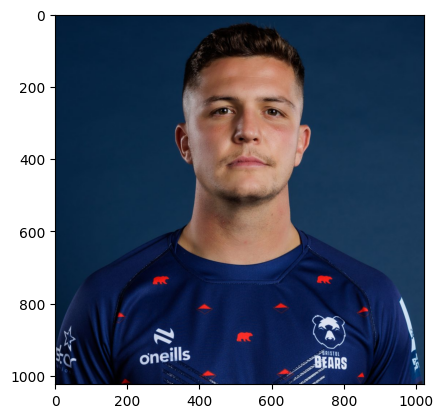

In [30]:
plt.imshow(image[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


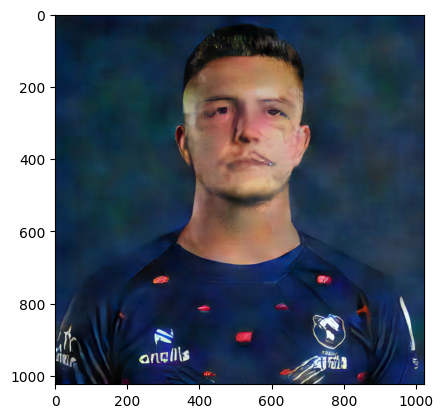

In [31]:
plt.imshow(rec_fmap[0].detach().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


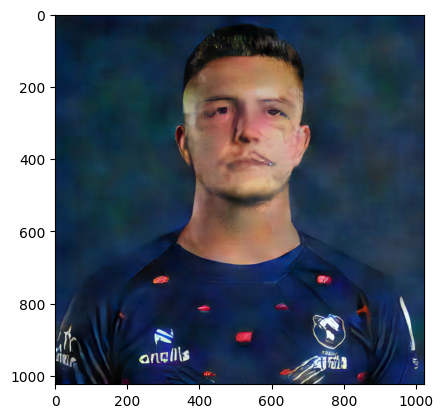

In [32]:
plt.imshow(rec_indc[0].detach().permute(1, 2, 0))